<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

Test what is the decoding change for single size training 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
from IPython.display import HTML

import POMDPgame_bars
from POMDPgame_bars import*

import POMDPgame_basic
from POMDPgame_basic import*

import POMDPgame_holes
from POMDPgame_holes import*


import RNN
from RNN import *

import navigation2
from navigation2 import*

import Nets
from Nets import*

%matplotlib inline

### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

task <class 'POMDPgame_basic.GameBasic'>
task <class 'POMDPgame_holes.GameHole'>
task <class 'POMDPgame_bars.GameBar'>
task <class 'POMDPgame_scale.GameScale'>
task <class 'POMDPgame_scale_x.GameScale_x'>
task <class 'POMDPgame_scale_y.GameScale_y'>
task <class 'POMDPgame_implicit.GameImplicit'>


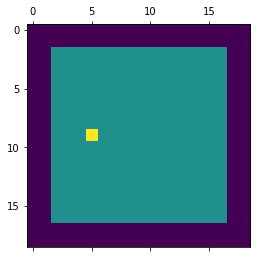

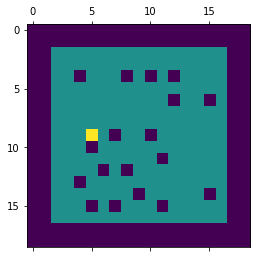

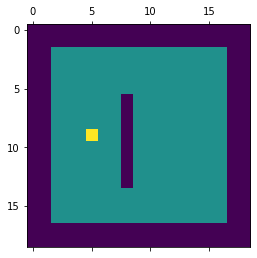

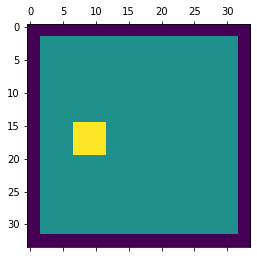

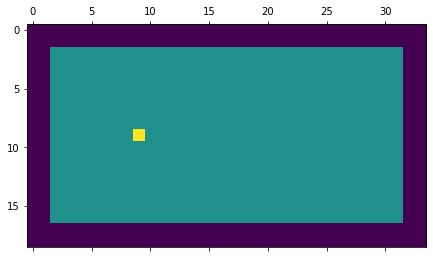

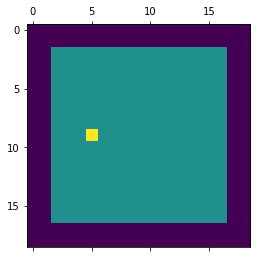

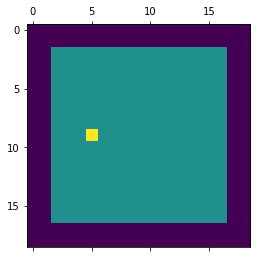

In [2]:
basicgame = CreateGame(GameBasic, holes = 0)
basicgame.reset(size = 15, reward_control=0)
plt.matshow(basicgame.grid.grid)

holegame = CreateGame(GameHole, holes = 50)
holegame.reset(size = 15, reward_control=0)
plt.matshow(holegame.grid.grid)

bargame = CreateGame(GameBar, holes = 0)
bargame.reset(size = 15, reward_control=0)
plt.matshow(bargame.grid.grid)

scalegame = CreateGame(GameScale, holes = 0)
scalegame.reset(reward_control=0)
plt.matshow(scalegame.grid.grid)

scalegame_x = CreateGame(GameScale_x, holes = 0)
scalegame_x.reset(reward_control=0)
plt.matshow(scalegame_x.grid.grid)

scalegame_y = CreateGame(GameScale_y, holes = 0)
scalegame_y.reset(reward_control=0)
plt.matshow(scalegame_y.grid.grid)

Imp_game = CreateGame(GameImplicit, holes = 0)
Imp_game.reset(size = 15, reward_control=0)
plt.matshow(Imp_game.grid.grid)

Think of how to make this traning stable, adding exploration noise , intenral noise or environmental variability like multiple mazes  

In [5]:
# moving bar train, noise = 0.0
trial = 399
tasks = ['basic', 'hole']
episodes = [10, 30, 30, 10, 30, 30, 30]
# iterations = [1, 1, 1, 1, 1, 1, 1]
for n, task in zip(episodes, tasks):
        Task =  MultipleTasks(task = task, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)\
                              , noise = 0.0)
        weight_read = Task.weight
        weight_write = 'weights_' + task + '/rnn_1515tanh512_checkpoint{}'.format(trial)
        if task == 'scale':
            size_train = np.arange(10, 51, 10)
        else:
            size_train = [15]
        if task == 'hole':
            iterations = 5
            epochs = 100
        else:
            iterations = 50
            epochs = 10
        print ('start', size_train)
        Task.qlearn(task, weight_read,  weight_write, episodes = n, noise = 0, size_train = size_train, size_test=[15], iterations = iterations
                   , epochs = epochs)

basic
start [15]
clear session data 49 2312249344
basic performance -0.4362678030755621
clear session data 49 2267299840
basic performance 0.7863129466682323
clear session data 49 2229624832
basic performance 0.8822660454237549
clear session data 49 2229624832
basic performance 0.7897966028011119
clear session data 49 2229624832
basic performance 0.8801521127266848
clear session data 49 2229624832
basic performance 0.8884561716324313
clear session data 49 2229624832
basic performance 0.8840812047698173
clear session data 49 2229624832
basic performance 0.8646426871468114
clear session data 49 2229624832
basic performance 0.867948078965218
clear session data 49 2229624832
basic performance 0.8985777217841986
hole
start [15]
clear session data 4 9539256320
hole performance -0.046962344418426796
clear session data 4 9997692928
hole performance -0.05627743622210882
clear session data 4 10032762880
hole performance 0.2890648359464867
clear session data 4 10094735360
hole performance 0.46801

AttributeError: 'ValueMaxGame' object has no attribute 'Set_reward'

In [ ]:
# moving bar train, noise = 0.0
trial = 399
tasks = ['bar']
episodes = [30]
# iterations = [1, 1, 1, 1, 1, 1, 1]
for n, task in zip(episodes, tasks):
        Task =  MultipleTasks(task = task, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)\
                              , noise = 0.0)
        weight_read = Task.weight
        weight_write = 'weights_' + task + '/rnn_1515tanh512_checkpoint{}'.format(trial)
        if task == 'scale':
            size_train = np.arange(10, 51, 10)
        else:
            size_train = [15]
        if (task == 'hole') or (task == 'bar'):
            iterations = 5
            epochs = 100
        else:
            iterations = 50
            epochs = 10 
        print ('start', size_train)
        Task.qlearn(task, weight_read,  weight_write, episodes = n, noise = 0, size_train = size_train, size_test=[15], iterations = iterations
                   , epochs = epochs)

bar
start [15]
clear session data 4 17593364480
bar performance -0.7213541666666667
clear session data 4 17593364480
bar performance -0.6455488445378151
clear session data 4 17593364480
bar performance -0.5384385131152372
clear session data 4 17593364480
bar performance -0.48932291666666666
clear session data 4 17593364480
bar performance -0.43525874035384904
clear session data 4 17593364480
bar performance -0.43126860119047616
clear session data 4 17593364480
bar performance -0.380967567431562
clear session data 4 17593364480
bar performance -0.33281926406926404
clear session data 4 17593364480
bar performance -0.3671640037593985
clear session data 4 17593364480
bar performance -0.3185374376780627
clear session data 4 17593364480
bar performance -0.21723211684149182
clear session data 4 17593364480
bar performance -0.015000949571262079
clear session data 4 17593364480
bar performance -0.08231894841269842
clear session data 4 17593364480
bar performance -0.07905362866300361
clear sessi

In [ ]:
# moving bar train, noise = 0.0
trial = 399
tasks = ['scale']
episodes = [10]
# iterations = [1, 1, 1, 1, 1, 1, 1]
for n, task in zip(episodes, tasks):
        Task =  MultipleTasks(task = task, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)\
                              , noise = 0.0)
        weight_read = Task.weight
        weight_write = 'weights_' + task + '/rnn_1515tanh512_checkpoint{}'.format(trial)
        if task == 'scale':
            size_train = np.arange(10, 51, 10)
        else:
            size_train = [15]
        if (task == 'hole') or (task == 'bar'):
            iterations = 5
            epochs = 100
        else:
            iterations = 50
            epochs = 10 
        print ('start', size_train)
        Task.qlearn(task, weight_read,  weight_write, episodes = n, noise = 0, size_train = size_train, size_test=[15], iterations = iterations
                   , epochs = epochs)

task <class 'POMDPgame_scale.GameScale'>
scale
start [10 20 30 40 50]


/home/tie/.conda/envs/torch/lib/python3.7/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


clear session data 49 4953993216
(9, 5)
(9, 13)
scale performance 0.33611628134796234


In [ ]:
# moving bar train, noise = 0.0
trial = 399
tasks = ['scale_x']
episodes = [30]
# iterations = [1, 1, 1, 1, 1, 1, 1]
for n, task in zip(episodes, tasks):
        Task =  MultipleTasks(task = task, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)\
                              , noise = 0.0)
        weight_read = Task.weight
        weight_write = 'weights_' + task + '/rnn_1515tanh512_checkpoint{}'.format(trial)
        if task == 'scale':
            size_train = np.arange(10, 51, 10)
        else:
            size_train = [15]
        if (task == 'hole') or (task == 'bar'):
            iterations = 5
            epochs = 100
        else:
            iterations = 50
            epochs = 10 
        print ('start', size_train)
        Task.qlearn(task, weight_read,  weight_write, episodes = n, noise = 0, size_train = size_train, size_test=[15], iterations = iterations
                   , epochs = epochs)

task <class 'POMDPgame_scale_x.GameScale_x'>
scale_x
start [15]


/home/tie/.conda/envs/torch/lib/python3.7/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


clear session data 49 1602179072
scale_x performance -0.614357049271784
clear session data 49 1924890624
scale_x performance -0.12836621780830826
clear session data 49 1924898816
scale_x performance -0.27205386307720514
clear session data 49 1925128192
scale_x performance 0.2289565362688739
clear session data 49 1925128192
scale_x performance 0.3723983833774887
clear session data 49 1925398528
scale_x performance 0.6268584164160191
clear session data 49 1925668864
scale_x performance 0.20934659639048744
clear session data 49 1925808128
scale_x performance 0.5387847803096268
clear session data 49 1925808128
scale_x performance 0.6466461672415948
clear session data 49 1925808128
scale_x performance 0.6581784130930551
clear session data 49 1925808128
scale_x performance 0.7641275677648225
clear session data 49 1926078464
scale_x performance 0.8739386962328441
clear session data 49 1926348800
scale_x performance 0.7818670661839535
clear session data 49 1926348800
scale_x performance 0.7978

In [3]:
# moving bar train, noise = 0.0
trial = 399
tasks = ['scale_y']
episodes = [30]
# iterations = [1, 1, 1, 1, 1, 1, 1]
for n, task in zip(episodes, tasks):
        Task =  MultipleTasks(task = task, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)\
                              , noise = 0.0)
        weight_read = Task.weight
        weight_write = 'weights_' + task + '/rnn_1515tanh512_checkpoint{}'.format(trial)
        if task == 'scale':
            size_train = np.arange(10, 51, 10)
        else:
            size_train = [15]
        if (task == 'hole') or (task == 'bar'):
            iterations = 5
            epochs = 100
        else:
            iterations = 50
            epochs = 10 
        print ('start', size_train)
        Task.qlearn(task, weight_read,  weight_write, episodes = n, noise = 0, size_train = size_train, size_test=[15], iterations = iterations
                   , epochs = epochs)

task <class 'POMDPgame_scale_y.GameScale_y'>
scale_y
start [15]


/home/tie/.conda/envs/torch/lib/python3.7/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


clear session data 49 1552498688
scale_y performance -0.1475947715941989
clear session data 49 1778864128
scale_y performance -0.2568936771122899
clear session data 49 1822928896
scale_y performance 0.34495650120797283
clear session data 49 1823211520
scale_y performance -0.029815214737947265
clear session data 49 1823600640
scale_y performance 0.17786481313832003
clear session data 49 1823379456
scale_y performance -0.17192887958217834
clear session data 49 1823395840
scale_y performance 0.04712986734727899
clear session data 49 1823666176
scale_y performance -0.1566897530812853
clear session data 49 1823846400
scale_y performance -0.09202431204261699
clear session data 49 1823850496
scale_y performance -0.09731937396222021
clear session data 49 1824112640
scale_y performance -0.2861627606267684
clear session data 49 1824124928
scale_y performance -0.4148447350206051
clear session data 49 1899950080
scale_y performance -0.3400537790079993
clear session data 49 1899950080
scale_y perfo

In [ ]:
# moving bar train noise 0.2
trial = 399
tasks = [ 'scale_xy']
episodes = [30]
# iterations = [1, 1, 1, 1, 1, 1, 1]
for n, task in zip(episodes, tasks):
        Task =  MultipleTasks(task = task, weight_write = 'weights_cpu/rnn_1515tanh512_checkpoint{}'.format(trial)\
                              , noise = 0.0)
        weight_read = Task.weight
        weight_write = 'weights_' + task + '/rnn_1515tanh512_checkpoint{}'.format(trial)
        if task == 'scale':
            size_train = np.arange(10, 51, 10)
        else:
            size_train = [15]
        if (task == 'hole') or (task == 'bar'):
            iterations = 5
            epochs = 100
            print ('hole', iterations, epochs)
        else:
            iterations = 50
            epochs = 20
        print ('start', size_train, Task.game.holes)
        Task.qlearn(task, weight_read,  weight_write, episodes = n, noise = 0, size_train = size_train, size_test=[15], iterations = iterations
                   , epochs = epochs)

task <class 'POMDPgame_scale_xy.GameScale_xy'>
scale_xy
start [15] 0


/home/tie/.conda/envs/torch/lib/python3.7/site-packages/torch/tensor.py:339: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


clear session data 49 2989703168
scale_xy performance -0.5210801823640594
clear session data 49 12056076288
scale_xy performance -0.27990230575743485
clear session data 49 12056084480


### measure decoding 

Decoding accuracy decreases, there are two possible reasons: 
1, decoding has bias,  information of position is only refleted by decoding, if there is certain bias , it is not trustable
2, it is the real measure of information, so there are less spatial information about space, or an effect decoupling/disentanglement of position. This can be due the network succeed at finding an even lower diemnsion object which gives successful performance.  The representation deceases its information to input in a sense. 

This can be linked to receptive field by looking at how space is represented. 